In [2]:
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms

In [3]:
image_path = "../data"

In [4]:
def get_smile(attr):
    return attr[18]

In [5]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop([178, 178]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [6]:
transform_val = transforms.Compose(
    [
        transforms.CenterCrop([178, 178]),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [7]:
import pytorch_lightning as pl
from torch.utils.data import Subset, DataLoader

In [8]:
class CelebADataset(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.save_hyperparameters()

    def get_smile(self, attr):
        return attr[18]

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.celeba_train = torchvision.datasets.CelebA(
                self.data_dir,
                split="train",
                target_type="attr",
                transform=transform_train,
                target_transform=self.get_smile,
                download=False,
            )
            self.celeba_val = torchvision.datasets.CelebA(
                self.data_dir,
                split="valid",
                target_type="attr",
                transform=transform_val,
                target_transform=self.get_smile,
                download=False,
            )

            self.celeba_train = Subset(self.celeba_train, torch.arange(50000))
            self.celeba_val = Subset(self.celeba_val, torch.arange(2000))

        if stage == "test" or stage is None:
            self.celeba_test = torchvision.datasets.CelebA(
                self.data_dir,
                split="test",
                target_type="attr",
                transform=transform_val,
                target_transform=self.get_smile,
                download=False,
            )

    def train_dataloader(self):
        return DataLoader(
            self.celeba_train, batch_size=self.batch_size, shuffle=True, num_workers=0
        )

    def val_dataloader(self):
        return DataLoader(self.celeba_val, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.celeba_test, batch_size=self.batch_size, num_workers=0)

In [9]:
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
from pytorch_lightning.loggers import TensorBoardLogger

In [11]:
class SmileClassifier(pl.LightningModule):
    def __init__(self, dropout_rate=0.3, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        self.res_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.res_shortcut1 = nn.Conv2d(3, 32, kernel_size=1)
        self.res_dropout1 = nn.Dropout(p=dropout_rate)
        self.res_pool1 = nn.MaxPool2d(kernel_size=2)

        self.res_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.res_shortcut2 = nn.Conv2d(32, 64, kernel_size=1)
        self.res_dropout2 = nn.Dropout(p=dropout_rate)
        self.res_pool2 = nn.MaxPool2d(kernel_size=2)

        self.res_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.res_shortcut3 = nn.Conv2d(64, 128, kernel_size=1)
        self.res_dropout3 = nn.Dropout(p=dropout_rate)
        self.res_pool3 = nn.MaxPool2d(kernel_size=2)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

        self.loss_fn = nn.BCELoss()

    def forward(self, x):
        identity = self.res_shortcut1(x)
        x = self.res_block1(x)
        x = x + identity
        x = self.res_pool1(self.res_dropout1(x))

        identity = self.res_shortcut2(x)
        x = self.res_block2(x)
        x = x + identity
        x = self.res_pool2(self.res_dropout2(x))

        identity = self.res_shortcut3(x)
        x = self.res_block3(x)
        x = x + identity
        x = self.res_pool3(self.res_dropout3(x))

        x = self.global_pool(x)
        x = self.classifier(x)

        return x

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.01
        )

        if self.trainer.max_epochs is None:
            max_epochs = 30
        else:
            max_epochs = self.trainer.max_epochs

        try:
            train_batches = len(self.trainer.train_dataloader)
        except Exception:
            train_batches = len(self.trainer.datamodule.train_dataloader())

        total_steps = train_batches * max_epochs

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.hparams.learning_rate,
            total_steps=total_steps,
            pct_start=0.3,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)[:, 0]
        loss = self.loss_fn(pred, y.float())

        acc = ((pred >= 0.5).float() == y).float().mean()

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)[:, 0]
        loss = self.loss_fn(pred, y.float())

        acc = ((pred >= 0.5).float() == y).float().mean()

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)[:, 0]
        loss = self.loss_fn(pred, y.float())

        acc = ((pred >= 0.5).float() == y).float().mean()

        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", acc, on_epoch=True)

        return loss

In [12]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MAX_EPOCHS = 30

device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
data_module = CelebADataset(data_dir=image_path, batch_size=BATCH_SIZE)
data_module.setup()

In [16]:
model = SmileClassifier(learning_rate=LEARNING_RATE)

In [17]:
callbacks = [
    ModelCheckpoint(
        monitor="val_acc",
        mode="max",
        filename="best-checkpoint",
        save_top_k=1,
        verbose=True,
    ),
    EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=True),
    LearningRateMonitor(logging_interval="step"),
]

logger = TensorBoardLogger("lightning_logs", name="smile_detection")

In [18]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator=device,
    devices=1,
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=10,
    deterministic=True,
    gradient_clip_val=1.0,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mamdouh_malaa/Developer/others/dl-project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [19]:
pl.seed_everything(42)

trainer.fit(model, data_module)

Seed set to 42

   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | res_block1    | Sequential        | 10.3 K | train
1  | res_shortcut1 | Conv2d            | 128    | train
2  | res_dropout1  | Dropout           | 0      | train
3  | res_pool1     | MaxPool2d         | 0      | train
4  | res_block2    | Sequential        | 55.7 K | train
5  | res_shortcut2 | Conv2d            | 2.1 K  | train
6  | res_dropout2  | Dropout           | 0      | train
7  | res_pool2     | MaxPool2d         | 0      | train
8  | res_block3    | Sequential        | 221 K  | train
9  | res_shortcut3 | Conv2d            | 8.3 K  | train
10 | res_dropout3  | Dropout           | 0      | train
11 | res_pool3     | MaxPool2d         | 0      | train
12 | global_pool   | AdaptiveAvgPool2d | 0      | train
13 | classifier    | Sequential        | 8.3 K  | train
14 | loss_fn       | BCELoss           | 0      | train
--------------------------

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s]

/Users/mamdouh_malaa/Developer/others/dl-project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/mamdouh_malaa/Developer/others/dl-project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1563/1563 [08:29<00:00,  3.07it/s, v_num=8, train_loss_step=0.512, train_acc_step=0.688, val_loss=0.368, val_acc=0.831, train_loss_epoch=0.537, train_acc_epoch=0.726]

Metric val_acc improved. New best score: 0.831
Epoch 0, global step 1563: 'val_acc' reached 0.83150 (best 0.83150), saving model to 'lightning_logs/smile_detection/version_8/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 1563/1563 [08:46<00:00,  2.97it/s, v_num=8, train_loss_step=0.413, train_acc_step=0.750, val_loss=0.543, val_acc=0.812, train_loss_epoch=0.339, train_acc_epoch=0.853] 

Epoch 1, global step 3126: 'val_acc' was not in top 1


Epoch 2: 100%|██████████| 1563/1563 [10:11<00:00,  2.56it/s, v_num=8, train_loss_step=0.0767, train_acc_step=1.000, val_loss=0.249, val_acc=0.892, train_loss_epoch=0.291, train_acc_epoch=0.874]

Metric val_acc improved by 0.061 >= min_delta = 0.0. New best score: 0.892
Epoch 2, global step 4689: 'val_acc' reached 0.89250 (best 0.89250), saving model to 'lightning_logs/smile_detection/version_8/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 3: 100%|██████████| 1563/1563 [09:31<00:00,  2.73it/s, v_num=8, train_loss_step=0.202, train_acc_step=0.875, val_loss=0.229, val_acc=0.901, train_loss_epoch=0.260, train_acc_epoch=0.888] 

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.901
Epoch 3, global step 6252: 'val_acc' reached 0.90100 (best 0.90100), saving model to 'lightning_logs/smile_detection/version_8/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 4: 100%|██████████| 1563/1563 [09:32<00:00,  2.73it/s, v_num=8, train_loss_step=0.0821, train_acc_step=0.938, val_loss=0.239, val_acc=0.906, train_loss_epoch=0.241, train_acc_epoch=0.896]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.906
Epoch 4, global step 7815: 'val_acc' reached 0.90650 (best 0.90650), saving model to 'lightning_logs/smile_detection/version_8/checkpoints/best-checkpoint.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1563/1563 [09:32<00:00,  2.73it/s, v_num=8, train_loss_step=0.0821, train_acc_step=0.938, val_loss=0.239, val_acc=0.906, train_loss_epoch=0.241, train_acc_epoch=0.896]


In [20]:
trainer.test(model, data_module)

/Users/mamdouh_malaa/Developer/others/dl-project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 624/624 [01:16<00:00,  8.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8928965330123901     │
│         test_loss         │    0.25438061356544495    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25438061356544495, 'test_acc': 0.8928965330123901}]

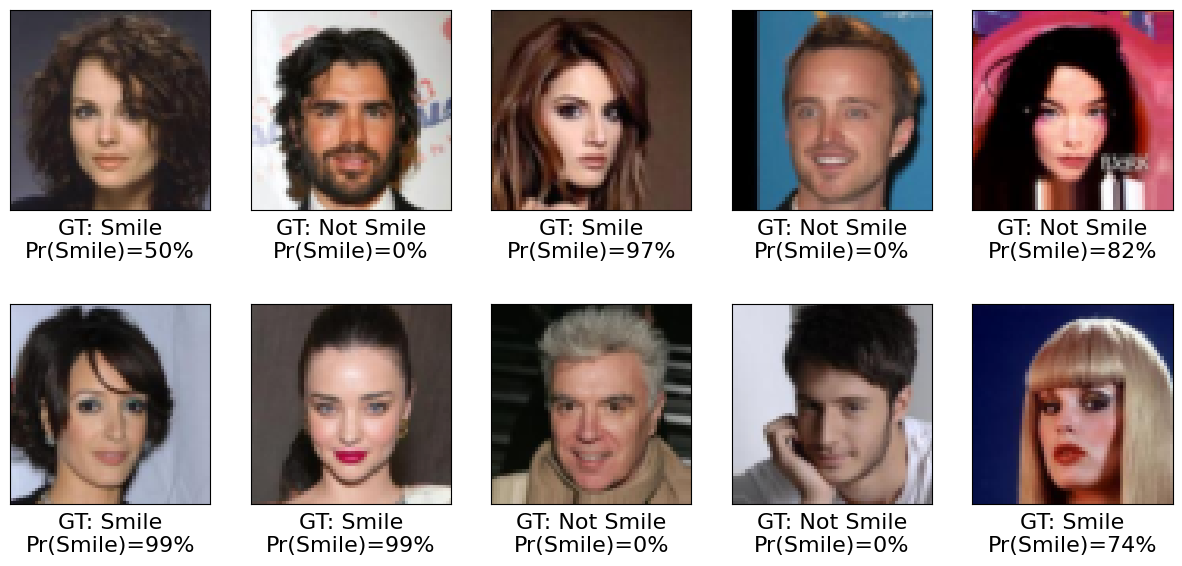

In [34]:
import matplotlib.pyplot as plt

val_loader = data_module.val_dataloader()
x_batch, y_batch = next(iter(val_loader))

x_batch = x_batch.to(model.device)
y_batch = y_batch.to(model.device)

with torch.no_grad():
    pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
x_orig = x_batch * std[None, :, None, None] + mean[None, :, None, None]

for j in range(10):
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_orig[j].cpu().permute(1, 2, 0).clamp(0, 1))

    label = "Smile" if y_batch[j] == 1 else "Not Smile"
    ax.text(
        0.5,
        -0.15,
        f"GT: {label}\nPr(Smile)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


In [35]:
def get_predictions(model, data_loader):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(model.device)
            y_batch = y_batch.to(model.device)
            pred = model(x_batch)[:, 0]
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


test_loader = data_module.test_dataloader()
all_preds, all_labels = get_predictions(model, test_loader)

In [40]:
sorted_indices = np.argsort(all_preds)[::-1]
sorted_labels = all_labels[sorted_indices]

n_pos = np.sum(all_labels == 1)
n_neg = len(all_labels) - n_pos
tpr = np.cumsum(sorted_labels) / n_pos
fpr = np.cumsum(1 - sorted_labels) / n_neg

auc_score = trapezoid(y=tpr, x=fpr)
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9640


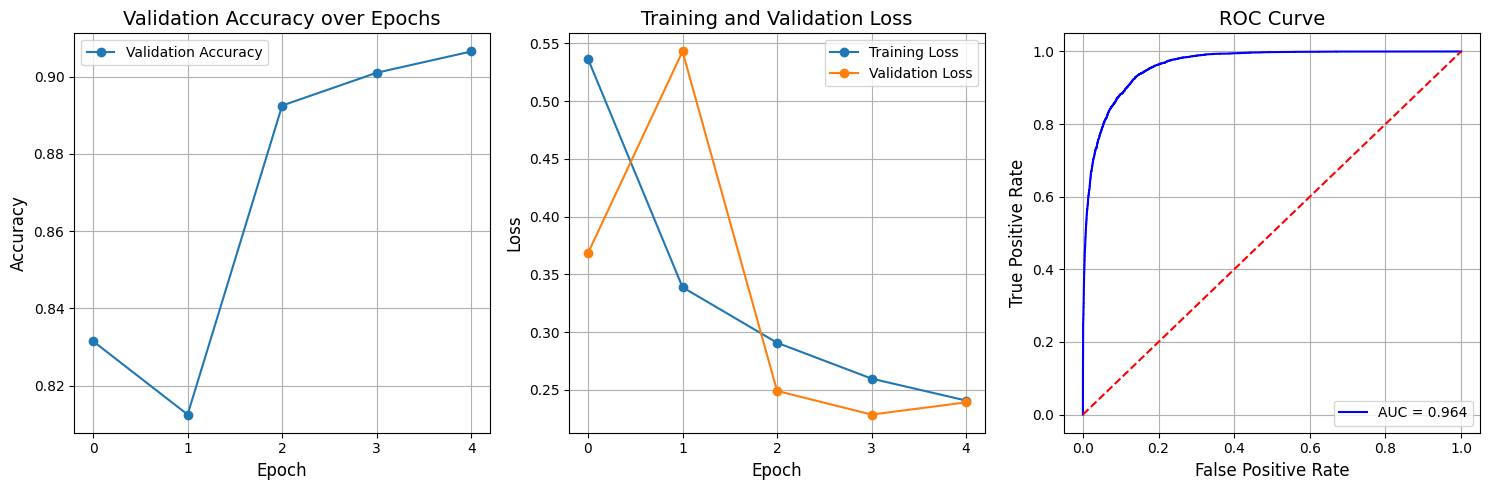

In [43]:
version = trainer.logger.version
log_dir = f"lightning_logs/smile_detection/version_{version}"
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

train_batches = len(data_module.train_dataloader())

val_acc = [(s.step // train_batches, s.value) for s in event_acc.Scalars("val_acc")]
train_loss = [
    (s.step // train_batches, s.value) for s in event_acc.Scalars("train_loss_epoch")
]
val_loss = [(s.step // train_batches, s.value) for s in event_acc.Scalars("val_loss")]

val_acc_steps, val_acc_values = zip(*val_acc)
train_loss_steps, train_loss_values = zip(*train_loss)
val_loss_steps, val_loss_values = zip(*val_loss)

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131)
ax1.plot(val_acc_steps, val_acc_values, "-o", label="Validation Accuracy")
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Validation Accuracy over Epochs", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax2 = fig.add_subplot(132)
ax2.plot(train_loss_steps, train_loss_values, "-o", label="Training Loss")
ax2.plot(val_loss_steps, val_loss_values, "-o", label="Validation Loss")
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title("Training and Validation Loss", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax3 = fig.add_subplot(133)

ax3.plot(fpr, tpr, "b-", label=f"AUC = {auc_score:.3f}")
ax3.plot([0, 1], [0, 1], "r--")
ax3.set_xlabel("False Positive Rate", fontsize=12)
ax3.set_ylabel("True Positive Rate", fontsize=12)
ax3.set_title("ROC Curve", fontsize=14)
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()